## Text Classification
While images contain local spatial correlations and structure, many other datasets
contain temporal correlations. Examples include time series and discrete se-
quences such as text. In this problem, we will tackle the task of text classica-
tion in the context of cybersecurity.

**Background**:

When malware infects a host computer, it often needs to
reach out to an outside server for further instructions or to download additional
payloads. This outside server is called a Command-and-Control server (C2).

The malware needs to send a specific communication to the C2 server, thus the
C2 server needs to have a registered IP address or associated web domain so
that it can be reached. Therefore, being able to identify web domains that are
likely related to malware C2 can be a valuable cyber defense.

**Dataset**:

Fortunately, security researchers have already identified and logged
a large number of malicious URLs. Additionally, we can catalog common "be-
nign" URLs just from typical web behavior (these would include things like
facebook.com and amazon.com). Hence, we have a labeled dataset for text
classification which can be downloaded here:


https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt
    
https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt

### Loading Package

In [147]:
import numpy as np
# --- Libraries ---
# - Base libs - 
import os
import numpy as np

# -Tensorflow-
import tensorflow as tf
from tensorflow.python.client import device_lib
# -Keras libs-
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint


# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display
#%matplotlib inline

In [148]:
# --- Set base path ---
cwd = os.getcwd()

### data Process

In [149]:
import urllib.request
myurl= "https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt"
with urllib.request.urlopen(myurl) as url:
    good_url= url.readlines()

In [150]:
import urllib.request
myurl= "https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt"
with urllib.request.urlopen(myurl) as url:
    bad_url= url.readlines()
    

- Python 3.x makes a clear distinction between the types:

- str = '...' literals = a sequence of Unicode characters (UTF-16 or UTF-32, depending on how Python was compiled)

- bytes = b'...' literals = a sequence of octets (integers between 0 and 255)


In [151]:
good_url_=[]
for i in good_url:
    if i[0]==35:
        next
    else:
        good_url_.append(list(i))     

In [152]:
bad_url_=[]
for i in bad_url:
    if i[0]==35:
        next
    else:
        bad_url_.append(list(i))

In [153]:
#preprocess data
all_url=good_url_+bad_url_
all_url_labels=[0 for i in range(len(good_url_))]+[1 for i in range(len(bad_url_))]

#split train and test data
import random
num_all_url=len(all_url)
num_train=np.int(np.floor(num_all_url*0.6))
index_train=random.sample(range(num_all_url),num_train)
index_test=[i for i in range(num_all_url) if i not in index_train]

In [154]:
max_len=0
for i in all_url:
    if len(i)>max_len:
        max_len=len(i)

In [156]:
input_train=np.array(all_url)[index_train]
input_test=np.array(all_url)[index_test]

y_train=np.array(all_url_labels)[index_train]
y_test=np.array(all_url_labels)[index_test]

In [157]:


from keras.preprocessing import sequence

# Max number of words
max_features = 10000

# Max length of sentence
maxlen = 87 

# Max number of comments read in at at ime
batch_size = 64

print('...Loading Data...')

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequence (sample x time)')
input_train = sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

...Loading Data...
40386 train sequences
26925 test sequences
Pad sequence (sample x time)
input_train shape: (40386, 87)
input_test shape: (26925, 87)


### RNN for text classification

In [167]:
# --- Training model: Embedding + RNN ---
model = Sequential()
model.add(Embedding(max_features, 64))
#model.add(SimpleRNN(32))
#model.add(GRU(32))
model.add(LSTM(32))
model.add(Dense(1, activation ='sigmoid'))

# --- Visualizing the model ---
#show_model_now = True
#if (show_model_now):
 #   display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
#else:
    # saves model in directory
#    plot_model(model,
 #              to_file=os.path.join(cwd,'model.png'))

In [168]:
# --- Locations to save model ---
save_path_weights = os.path.join(cwd,'rnn_weights.h5')
save_path_model = os.path.join(cwd,'rnn_model.h5')

# --- Compile Model ---
#Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

# If we want to checkpoint our model so we don't rerun it
checkpointer = ModelCheckpoint(filepath=save_path_weights, 
                               verbose=1, save_best_only=True)


# Verbose=0 -> to avoid jupyter notebook freezing
history = model.fit(input_train, y_train, 
                    epochs = 3, batch_size = 64, 
                    validation_split = 0.2,verbose=1)

Train on 32308 samples, validate on 8078 samples
Epoch 1/3
32308/32308 [==============================] - 82s - loss: 0.0763 - acc: 0.9787 - val_loss: 0.0469 - val_acc: 0.9817
Epoch 2/3
32308/32308 [==============================] - 78s - loss: 0.0337 - acc: 0.9850 - val_loss: 0.0271 - val_acc: 0.9880
Epoch 3/3
32308/32308 [==============================] - 77s - loss: 0.0277 - acc: 0.9870 - val_loss: 0.0251 - val_acc: 0.9901


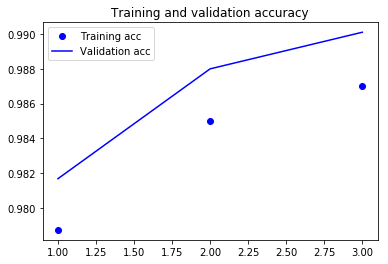

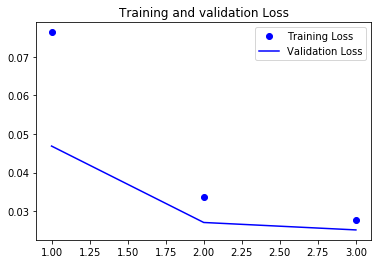

In [169]:
# --- Plotting performance ---
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation Loss')
plt.legend()

plt.show()

In [161]:
score = model.evaluate(input_test , y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0276537539718
Test accuracy: 0.98681522749


### CNN for text classification

In [143]:
%pylab inline

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from PIL import Image

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [144]:
max_features = 255
maxlen = 87
batch_size = 32

In [145]:
# =============================
#  Setting up LeNet Architecture
# ============================
model2 = Sequential()
model2.add(Embedding(max_features, 64,input_length=87))
model2.add(Conv1D(filters = 4,kernel_size=5, 
                 activation='relu',  
                 padding='valid',input_shape=(87,64,1)))
model2.add(MaxPooling1D(pool_size=3))

model2.add(Conv1D(filters = 4,kernel_size=5, 
                 activation='relu',  
                 padding='valid'))
model2.add(MaxPooling1D(pool_size=3))
model2.add(Dropout(0.5))

model2.add(Conv1D(filters = 4,kernel_size=5, 
                 activation='relu',  
                 padding='valid'))
model2.add(Flatten())
#dense layer
model2.add(Dense(1, activation ='sigmoid'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 87, 64)            16320     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 83, 4)             1284      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 27, 4)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 23, 4)             84        
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 7, 4)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 4)              0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 3, 4)              84        
__________

model_conv = Sequential()
model_conv.add(Embedding(10000, 100, input_length=50))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.summary()

In [146]:
#compile the model and train
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Verbose=0 -> to avoid jupyter notebook freezing
history = model2.fit(input_train, y_train, 
                    epochs = 3, batch_size = 64, 
                    validation_split = 0.2,verbose=1)

Train on 32308 samples, validate on 8078 samples
Epoch 1/3
32308/32308 [==============================] - 11s - loss: 0.1297 - acc: 0.9811 - val_loss: 0.0767 - val_acc: 0.9799
Epoch 2/3
32308/32308 [==============================] - 8s - loss: 0.0755 - acc: 0.9814 - val_loss: 0.0744 - val_acc: 0.9799
Epoch 3/3
32308/32308 [==============================] - 8s - loss: 0.0726 - acc: 0.9814 - val_loss: 0.0714 - val_acc: 0.9799


In [141]:
score2 = model2.evaluate(input_test , y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Test loss: 0.0734445432832
Test accuracy: 0.980167130919


### 3.3 Compare models using ROC curve

Here we use the roc curve to compare the models. It shows the RNN has a better performance.

In [170]:
from sklearn.metrics import roc_curve
y_pred_keras_2 = model2.predict(input_test).ravel()
fpr_keras_2, tpr_keras_2, thresholds_keras_2 = roc_curve(y_test, y_pred_keras_2)
from sklearn.metrics import auc
auc_keras_2 = auc(fpr_keras_2, tpr_keras_2)

In [171]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(input_test).ravel()
fpr_keras, tpr_keras, thresholds_keras= roc_curve(y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

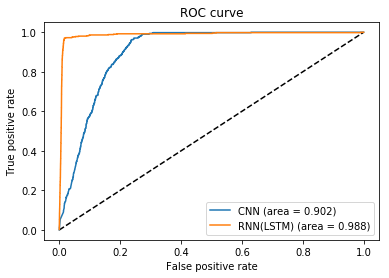

In [173]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_2, tpr_keras_2, label='CNN (area = {:.3f})'.format(auc_keras_2))
plt.plot(fpr_keras, tpr_keras, label='RNN(LSTM) (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()